# OpenML Metafeatures

In this notebook, we examine the available metafeatures for datasets provided by OpenML. We first analyse them and then check how much they improve model performance. First, we load the data.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from src import configuration as config
from src.features.encoder_utils import get_metafeatures
from src.pipeline.pipeline_factory import PipelineFactory, ModelType, EvaluationType
from src.pipeline.pipeline_transformers import OpenMLMetaFeatureTransformer
from category_encoders.target_encoder import TargetEncoder

c:\users\thomas\appdata\local\programs\python\python38\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_df = config.load_traindata_for_regression()

## Examining OpenML Metafeatures

Let us first look at what metafeatures the OpenML framework provides.

In [3]:
datasets = pd.Series(train_df['dataset'].unique())
metafeatures = get_metafeatures(datasets)

In [4]:
metafeatures.head(10)

,AutoCorrelation,CfsSubsetEval_DecisionStumpAUC,CfsSubsetEval_DecisionStumpErrRate,CfsSubsetEval_DecisionStumpKappa,CfsSubsetEval_NaiveBayesAUC,CfsSubsetEval_NaiveBayesErrRate,CfsSubsetEval_NaiveBayesKappa,CfsSubsetEval_kNN1NAUC,CfsSubsetEval_kNN1NErrRate,CfsSubsetEval_kNN1NKappa,...,RandomTreeDepth2AUC,RandomTreeDepth2ErrRate,RandomTreeDepth2Kappa,RandomTreeDepth3AUC,RandomTreeDepth3ErrRate,RandomTreeDepth3Kappa,StdvNominalAttDistinctValues,kNN1NAUC,kNN1NErrRate,kNN1NKappa
id,,,,,,,,,,,,,,,,,,,,,
1169,0.580513,0.662639,0.357881,0.247825,0.662639,0.357881,0.247825,0.662639,0.357881,0.247825,...,0.603066,0.396288,0.186598,0.603066,0.396288,0.186598,155.660849,0.604123,0.402286,0.174082
42178,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,0.996587,0.799052,0.210884,0.542654,0.799052,0.210884,0.542654,0.799052,0.210884,0.542654,...,0.755854,0.244898,0.466694,0.755854,0.244898,0.466694,0.744024,0.776897,0.214286,0.543726
1511,0.615034,0.892665,0.095455,0.785595,0.892665,0.095455,0.785595,0.892665,0.095455,0.785595,...,0.859793,0.125000,0.715629,0.859793,0.125000,0.715629,0.707107,0.868679,0.120455,0.727964
43922,0.726333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1037,0.621574,0.853067,0.153661,0.555710,0.853067,0.153661,0.555710,0.853067,0.153661,0.555710,...,0.723642,0.213722,0.425688,0.723642,0.213722,0.425688,11.580635,0.690086,0.228847,0.382664
1590,0.634426,0.881878,0.143708,0.563625,0.881878,0.143708,0.563625,0.881878,0.143708,0.563625,...,0.753893,0.189448,0.473234,0.753893,0.189448,0.473234,12.152960,0.714750,0.206380,0.430968
1112,0.863877,0.620748,0.073440,0.000000,0.553385,0.089840,0.017690,0.511428,0.124480,0.024421,...,0.537100,0.076820,0.000201,0.549366,0.089980,-0.000452,4160.398063,0.507318,0.124700,0.015721
43896,0.740640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
list(metafeatures.columns)

['AutoCorrelation',
 'CfsSubsetEval_DecisionStumpAUC',
 'CfsSubsetEval_DecisionStumpErrRate',
 'CfsSubsetEval_DecisionStumpKappa',
 'CfsSubsetEval_NaiveBayesAUC',
 'CfsSubsetEval_NaiveBayesErrRate',
 'CfsSubsetEval_NaiveBayesKappa',
 'CfsSubsetEval_kNN1NAUC',
 'CfsSubsetEval_kNN1NErrRate',
 'CfsSubsetEval_kNN1NKappa',
 'ClassEntropy',
 'DecisionStumpAUC',
 'DecisionStumpErrRate',
 'DecisionStumpKappa',
 'Dimensionality',
 'EquivalentNumberOfAtts',
 'J48.00001.AUC',
 'J48.00001.ErrRate',
 'J48.00001.Kappa',
 'J48.0001.AUC',
 'J48.0001.ErrRate',
 'J48.0001.Kappa',
 'J48.001.AUC',
 'J48.001.ErrRate',
 'J48.001.Kappa',
 'MajorityClassPercentage',
 'MajorityClassSize',
 'MaxAttributeEntropy',
 'MaxKurtosisOfNumericAtts',
 'MaxMeansOfNumericAtts',
 'MaxMutualInformation',
 'MaxNominalAttDistinctValues',
 'MaxSkewnessOfNumericAtts',
 'MaxStdDevOfNumericAtts',
 'MeanAttributeEntropy',
 'MeanKurtosisOfNumericAtts',
 'MeanMeansOfNumericAtts',
 'MeanMutualInformation',
 'MeanNoiseToSignalRatio',


We have a large number of different metafeatures with 107. They cover different properties of the dataset:
- Simple: 'NumberOfFeatures', 'NumberOfInstances', 'NumberOfMissingValues', ...
- Statistical: 'MeanMeansOfNumericAtts', 'MeanStdDevOfNumericAtts', ...
- Information-theoretic: 'MaxAttributeEntropy', 'MeanAttributeEntropy', 'MinAttributeEntropy', ...
- Model-based: 'RandomTreeDepth1ErrRate', 'RandomTreeDepth2ErrRate', 'RandomTreeDepth3ErrRate', ...
- Landmarking: 'NaiveBayesErrRate', 'REPTreeDepth1ErrRate', 'kNN1NErrRate', ...

Let us examine, whether there are missing entries (nan).

In [6]:
not_nan_count = metafeatures.notna().sum().sum()
nan_count = metafeatures.isna().sum().sum()

print('total:', not_nan_count + nan_count)
print('nan (abs.):', nan_count)
print('nan (rel.):', '{:.2%}'.format(nan_count / (nan_count + not_nan_count)))

total: 5350
nan (abs.): 1782
nan (rel.): 33.31%


We have an extremely large number of missing values. Let us check if it depends on the dataset.

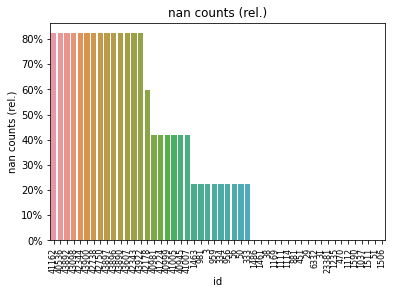

In [46]:
nan_count_per_dataset = pd.DataFrame(
    metafeatures.isna().sum(axis=1) / (metafeatures.isna().sum(axis=1) + metafeatures.notna().sum(axis=1)), 
    columns=['nan counts (rel.)']
).sort_values(by='nan counts (rel.)', ascending=False).reset_index()

sns.barplot(x=nan_count_per_dataset['id'], y=nan_count_per_dataset['nan counts (rel.)'], order=nan_count_per_dataset['id'])
plt.title('nan counts (rel.)')
if len(nan_count_per_dataset) >= 10:
    plt.xticks(fontsize=8, rotation=90)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig('metafeatures_nan_by_dataset.svg')
plt.show()

There are datasets with complete metafeatures, while other have no values for more than 80% of features. Let us examine how it looks like for the individual features.

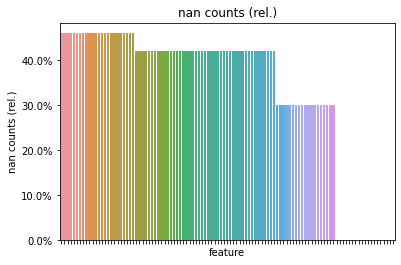

,nan counts (rel.),count
0,46.00%,24
1,42.00%,45
2,30.00%,19
3,0.00%,19


features with relative nan count of 0%:
    AutoCorrelation
    Dimensionality
    MajorityClassPercentage
    MajorityClassSize
    MinorityClassPercentage
    MinorityClassSize
    NumberOfBinaryFeatures
    NumberOfClasses
    NumberOfFeatures
    NumberOfInstances
    NumberOfInstancesWithMissingValues
    NumberOfMissingValues
    NumberOfNumericFeatures
    NumberOfSymbolicFeatures
    PercentageOfBinaryFeatures
    PercentageOfInstancesWithMissingValues
    PercentageOfMissingValues
    PercentageOfNumericFeatures
    PercentageOfSymbolicFeatures


In [47]:
nan_count_per_feature = pd.DataFrame(
    metafeatures.isna().sum(axis=0) / (metafeatures.isna().sum(axis=0) + metafeatures.notna().sum(axis=0)), 
    columns=['nan counts (rel.)']
).sort_values(by='nan counts (rel.)', ascending=False).reset_index().rename(columns={'index': 'feature'})

sns.barplot(x=nan_count_per_feature['feature'], y=nan_count_per_feature['nan counts (rel.)'], order=nan_count_per_feature['feature'])
plt.title('nan counts (rel.)')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=True,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False
)
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig('metafeatures_nan_by_feature.svg')
plt.show()

levels = pd.DataFrame(nan_count_per_feature['nan counts (rel.)'].value_counts())
levels = levels.sort_values(by='nan counts (rel.)', ascending=False).reset_index()
levels['nan counts (rel.)'] = levels['nan counts (rel.)'].map(lambda n: '{:.2%}'.format(n))
display(levels)

print('features with relative nan count of 0%:')
for feature in sorted(list(nan_count_per_feature[nan_count_per_feature['nan counts (rel.)'] == 0]['feature'])):
    print('    ' + feature)

We see that there are features with a very high relative nan count of >40%. There are also features, which never contain a nan.

## Processing OpenML Metafeatures

We have seen, that there are two problems with the fetched metafeatures. First off, there are a lot of missing values (nan) with  33.31%. Ways to deal with this are either imputation or dropping features with too many missing values. Secondly, we have a large number of features with 107. For this case, we can also drop features or we could apply a principal component analysis. In the following section, we try the different approaches and combinations of these.

#### 'Nan' Removal through Imputation and Metafeature Removal

The first step allows different variations, depending on which parameters we pass to the transformer:
- Impute all nan values with the attribute mean
- Remove features with a nan rate >= X% and for the remaining features impute with the attribute mean
- Remove features with any nan

#### Metafeature Reduction through PCA

In this step, we want to reduce the number of metafeatures. For this, we first standardize the data and then apply a principal component analysis where the desired explained variance is >= X%.

#### Dropping or Encoding the feature 'dataset'

The last step is to handle the original 'dataset' feature. We can either drop it or we might apply an additional standard encoder, e.g. TargetEncoder.

#### Performance Comparison

We want to evaluate the different approaches and pick the best one.

In [9]:
pipeline = PipelineFactory().create_pipeline(
    train_df,
    ModelType.REGRE_BASELINE,
    verbose_level=0,
    evaluation=EvaluationType.BASIC
)
pipeline.run()

In [10]:
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.preprocessing import OrdinalEncoder
from src.pipeline.pipeline_transformers import PoincareEmbedding, GeneralPurposeEncoderTransformer, OpenMLMetaFeatureTransformer
from src.features.encoder_utils import load_graph
import itertools

pipeline.add_new_step(
    PoincareEmbedding(load_graph(config.ROOT_DIR / "data/external/graphs/encodings_graph.adjlist")),
    'encoder_transformer'
)
pipeline.add_new_step(GeneralPurposeEncoderTransformer(), 'general_transformers')
pipeline.change_estimator(LGBMRegressor())

scores = {}
def evaluation(nan_ratio, variance, encoder):
    print('nan_ratio:', nan_ratio, 'variance:', variance, 'encoder:', encoder, end='')
    pipeline.add_new_step(
        OpenMLMetaFeatureTransformer(
            nan_ratio_feature_drop_threshold=nan_ratio,
            expected_pca_variance=variance,
            encoder=encoder
        ), 
        'dataset_transformer'
    )
    pipeline.run()
    score = pipeline._validation_performance_scores['validation_average_spearman']
    scores[(nan_ratio, variance, str(encoder))] = score
    print(' ->', score)

In [30]:
baselines = [
    (0, 1, None), # no metafeatues + drop dataset
    (0, 1, TargetEncoder()), # no metafeatures + encode dataset
    (1, 1, None), # all metafeatures with imputation + drop dataset
    (1, 1, TargetEncoder()) # all metafeatures with imputation + encode dataset
]
combinations = baselines + list(itertools.product(
    [0.25, 0.4, 0.45, 0.5], 
    [0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1],
    [None, TargetEncoder()]
))

for count, (nan_ratio, variance, encoder) in enumerate(combinations):
    print('[' + str(count + 1) + '/' + str(len(combinations)) + ']' + ' ', end='')
    evaluation(nan_ratio, variance, encoder)

[1/60] nan_ratio: 0 variance: 1 encoder: None -> 0.15166689337226757
[2/60] nan_ratio: 0 variance: 1 encoder: TargetEncoder() -> 0.2510768378403864
[3/60] nan_ratio: 1 variance: 1 encoder: None -> 0.283622473232926
[4/60] nan_ratio: 1 variance: 1 encoder: TargetEncoder() -> 0.2745440515178948
[5/60] nan_ratio: 0.25 variance: 0.6 encoder: None -> 0.2500523104340501
[6/60] nan_ratio: 0.25 variance: 0.6 encoder: TargetEncoder() -> 0.2812357985942342
[7/60] nan_ratio: 0.25 variance: 0.7 encoder: None -> 0.24166955742109364
[8/60] nan_ratio: 0.25 variance: 0.7 encoder: TargetEncoder(cols=['dataset']) -> 0.27488444247525357
[9/60] nan_ratio: 0.25 variance: 0.8 encoder: None -> 0.28528818317693233
[10/60] nan_ratio: 0.25 variance: 0.8 encoder: TargetEncoder(cols=['dataset']) -> 0.28000592171580685
[11/60] nan_ratio: 0.25 variance: 0.9 encoder: None -> 0.26855774217476414
[12/60] nan_ratio: 0.25 variance: 0.9 encoder: TargetEncoder(cols=['dataset']) -> 0.27025114766907066
[13/60] nan_ratio: 0.

In [35]:
def without_encoder(combination):
    return (
        combination[0],
        combination[1],
        "None"
    )

def with_encoder(combination):
    return (
        combination[0],
        combination[1],
        "TargetEncoder(cols=['dataset'])"
    )

baseline_without_encoder = (0, 1, "None")
baseline_with_encoder = (0, 1, "TargetEncoder(cols=['dataset'])")

best = max(scores, key=scores.get)
best_without_encoder = without_encoder(best)
best_with_encoder = with_encoder(best)

full_imputation_scores = {k: scores[k] for k in scores if k[0] >= 0.5}
full_imputation_best = max(full_imputation_scores, key=full_imputation_scores.get)
full_imputation_best_with_encoder = with_encoder(full_imputation_best)
full_imputation_best_without_encoder = without_encoder(full_imputation_best)

no_imputation_scores = {k: scores[k] for k in scores if k[0] == 0}
no_imputation_best = max(no_imputation_scores, key=no_imputation_scores.get)
no_imputation_best_with_encoder = with_encoder(no_imputation_best)
no_imputation_best_without_encoder = without_encoder(no_imputation_best)

no_pca_scores = {k: scores[k] for k in scores if k[1] == 1}
no_pca_best = max(no_pca_scores, key=no_pca_scores.get)
no_pca_best_with_encoder = with_encoder(no_pca_best)
no_pca_best_without_encoder = without_encoder(no_pca_best)

In [36]:
scores_df = pd.DataFrame()
for nan_ratio, variance, encoder in scores:
    scores_df = pd.concat([scores_df, pd.DataFrame({
        'nan_ratio': [nan_ratio],
        'variance': [variance],
        'encoder': [encoder == "TargetEncoder(cols=['dataset'])"],
        'score': [scores[(nan_ratio, variance, encoder)]]
    })])
scores_df = scores_df.sort_values(by='score', ascending=False).reset_index(drop=True)
display(scores_df)

,nan_ratio,variance,encoder,score
0,0.40,1.00,True,0.307505
1,0.40,0.90,True,0.301811
2,0.40,0.99,False,0.301405
3,0.45,0.95,True,0.298698
4,0.50,0.80,False,0.298063
...,...,...,...,...
67,0.00,0.80,False,0.151667
68,0.00,0.90,False,0.151667
69,0.00,0.95,False,0.151667
70,0.00,0.99,False,0.151667


In [37]:
data = pd.DataFrame()
for category, entry in [
    ('no metafeatures', baseline_with_encoder),
    ('no metafeatures', baseline_without_encoder),
    ('best (full imputation)', full_imputation_best_with_encoder),
    ('best (full imputation)', full_imputation_best_without_encoder),
    ('best (no imputation)', no_imputation_best_with_encoder),
    ('best (no imputation)', no_imputation_best_without_encoder),
    ('best (no pca)', no_pca_best_with_encoder),
    ('best (no pca)', no_pca_best_without_encoder),
    ('best (overall)', best_with_encoder),
    ('best (overall)', best_without_encoder),
    
]:    
    data = pd.concat([data, pd.DataFrame({
        'category': [category],
        'encoder': [entry[2] == "TargetEncoder(cols=['dataset'])"],
        'score': [scores[entry]]
    })])
data = data.reset_index(drop=True)

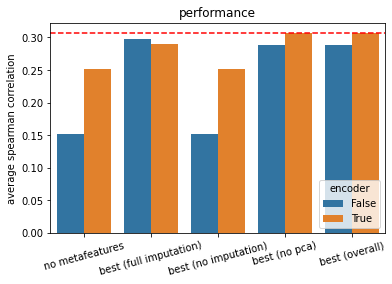

best paramters:
nan_ratio: 0.4
expected_variance: 1
encoder: True


In [56]:
sns.barplot(data=data, x='category', y='score', hue='encoder')
plt.axhline(y=scores[best], color='red', linestyle='--')
plt.title('performance')
plt.xlabel('')
plt.ylabel('average spearman correlation')
plt.xticks(rotation=15)
plt.legend(title='encoder', loc='lower right')
plt.gcf().subplots_adjust(bottom=0.15)
plt.savefig('metafeatures_performance.svg')
plt.show()

print('best paramters:')
print('nan_ratio:', best[0])
print('expected_variance:', best[1])
print('encoder:', best[2] != 'None')

We see that adding metafeatues had a big positive impact on the performance. We also observe a trend, that encoding the 'dataset' instead of dropping it after adding metafeatures results in higher performance. The best performing approach was to drop all metafeatures with a 'nan' ratio higher than 40% and imputing the rest, standardizing the features, skipping the principal component analysis and encoding the original 'dataset' feature with a TargetEncoder.